In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize 
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy import fftpack
import seaborn as sns

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

solution with initial guess x0 = [1,0]   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.0316284534875166
        x: [ 8.984e-02 -7.127e-01]
      nit: 5
      jac: [-8.882e-08  8.837e-06]
     nfev: 30
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
algorithm has converged and the global minimum is (x,y) =  [ 0.08984193 -0.71265586]


solution with initial guess x0 = [-1,0]   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.031628453487433
        x: [-8.984e-02  7.127e-01]
      nit: 5
      jac: [ 1.110e-07 -8.815e-06]
     nfev: 30
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
algorithm has converged and the global minimum is (x,y) =  [-0.08984193  0.71265585]


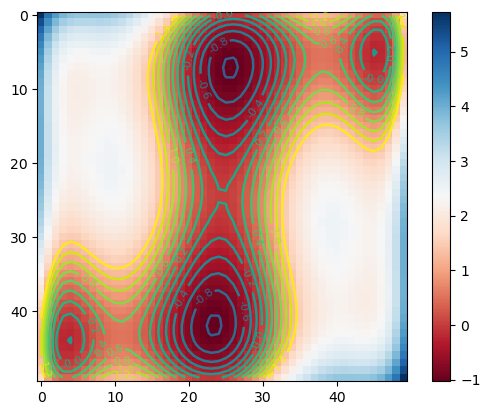

<Figure size 640x480 with 0 Axes>



The global minima found by changing the initial points are:

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.0316284534898768
        x: [-8.984e-02  7.127e-01]
      nit: 12
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.292e-01 -7.974e-03]
            [-7.974e-03  6.140e-02]]
     nfev: 45
     njev: 15


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.0316284534898768
        x: [ 8.984e-02 -7.127e-01]
      nit: 12
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.292e-01 -7.975e-03]
            [-7.975e-03  6.140e-02]]
     nfev: 45
     njev: 15




solution with initial guess x0 = [0,0]   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0
        x: [ 0.000e+00  0.000e+00]
      nit: 0
      jac: [ 4.000e-08 -4.000e-08]
     nfev: 3
     njev: 1
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

algorithm has converged and the gl

'With initial point (0,0) it gives as minimum (0,0). This is a local minimum'

In [7]:
#Find the global minima of this function
#minimize_scalar (search interval can be specified)
def f(v):
    return (4 - 2.1*v[0]**2 + (v[0]**4 / 3))*(v[0]**2) + v[0]*v[1] + (4*v[1]**2 - 4)*v[1]**2
    
# plot the minimum value
solution = optimize.minimize(f, x0=[1,0], bounds= [(-2,2),(-1,1)])
print("solution with initial guess x0 = [1,0]", solution)
if solution.message[:11] != "CONVERGENCE":
    print("no convergence\n")
else:
    print("algorithm has converged and the global minimum is (x,y) = ", solution.x)


solution = optimize.minimize(f, x0=[-1,0], bounds= [(-2,2),(-1,1)])
print("\n\nsolution with initial guess x0 = [-1,0]", solution)
if solution.message[:11] != "CONVERGENCE":
    print("no convergence\n")
else:
    print("algorithm has converged and the global minimum is (x,y) = ", solution.x)

    
#graphically display the regions
x = np.linspace(-2,2)
y = np.linspace(-1,1)
#to create a grid of points
xv, yv = np.meshgrid(x,y) 
#valuate  the function
z = f((xv, yv))
plot = plt.imshow(z, cmap = plt.cm.RdBu)  #the use of pylab.imshow() is strongly discouraged
# adding the Contour lines with labels
cset = plt.contour(z,np.arange(-2,1.5,0.2),linewidths=1.8)
plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=8)
plt.colorbar(plot) # adding the colobar on the right

#How many global minima are there, and what is the function value at those points?
fig = plt.figure()
#ax = plt.axes(projection='3d') 
ax = Axes3D(fig)
ax.plot_surface(xv, yv, z)
plt.show()

all_sol= []
#try to find all global minima by changing the initial point
initial_x = range(-2, 3)
initial_y = range(-1, 2)
for ix in initial_x:
    for  iy in initial_y:
        all_sol.append(optimize.minimize(f, x0 = [ix,iy]))
        
m = min([solution['fun'] for solution in all_sol])
print("\n\nThe global minima found by changing the initial points are %d:\n")
for v in all_sol:
    if v['fun'] == m:
        print(v)
        print("\n")


#What happens for an initial guess of  (𝑥,𝑦)=(0,0)?
solution_00 = optimize.minimize(f, x0=[0,0], bounds= [(-2,2),(-1,1)])
print("\n\nsolution with initial guess x0 = [0,0]", solution_00)
if solution_00.message[:11] != "CONVERGENCE":
    print("\nno convergence\n")
else:
    print("\nalgorithm has converged and the global minimum is (x,y) = ", solution_00.x)
    
'''With initial point (0,0) it gives as minimum (0,0). This is a local minimum'''

2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\Omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

Text(0.5, 1.0, 'Omega')

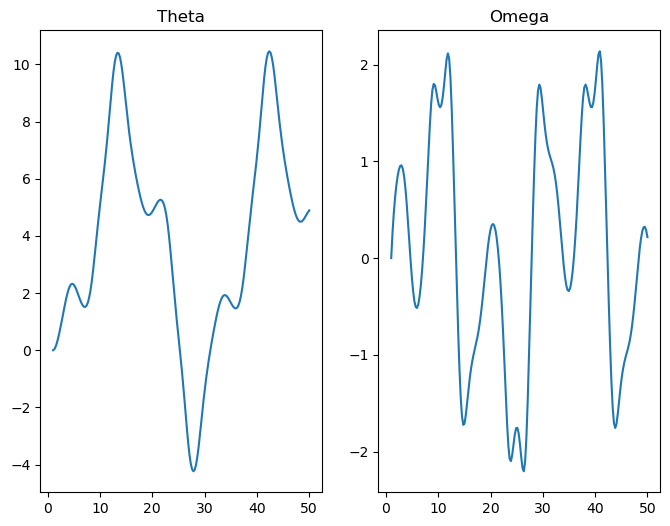

In [9]:
#Solve the ODE with odeint over a period of 200 time steps

# first, the function computing the derivative of the position needs to be defined
#freq_forcing = 1/T, with T = 2pi/omega
def derivative(V, t,l, Q, d, driv_f):
    g = 9.81#set constants
    return (V[1], -(1/Q)*V[1] + (g/l)*np.sin(V[0]) + d*np.cos(t*driv_f)) #return (dtheta = omega, domega)

# define the period of 200 time steps
tmax = 50
t = np.linspace(1, tmax, 200)

# V = [theta, omega]
V_init = (0,0) #(rad,rad/sec)
l = 10
Q = 2.0
d = 1.5
driv_f = 0.65
initial_conditions = (l, Q, d, driv_f)
V = odeint(derivative,V_init, t,args=(initial_conditions)) #V0 = theta, V1 = omega

#Create two plots, one of  𝜃  as a function of the time, and  𝜔  as a function of the time
fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
ax[0].plot(t,V[:,0])
ax[0].set_title("Theta")
ax[1].plot(t,V[:,1])
ax[1].set_title("Omega")
#Optional: determine if there is a set of parameters for which the motion is chaotic

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`


Year [1900. 1901. 1902. 1903. 1904. 1905. 1906. 1907. 1908. 1909. 1910. 1911.
 1912. 1913. 1914. 1915. 1916. 1917. 1918. 1919. 1920.] 

Hare [30000. 47200. 70200. 77400. 36300. 20600. 18100. 21400. 22000. 25400.
 27100. 40300. 57000. 76600. 52300. 19500. 11200.  7600. 14600. 16200.
 24700.] 

Lynx [ 4000.  6100.  9800. 35200. 59400. 41700. 19000. 13000.  8300.  9100.
  7400.  8000. 12300. 19500. 45700. 51100. 29700. 15800.  9700. 10100.
  8600.] 

Carrot [48300. 48200. 41500. 38200. 40600. 39800. 38600. 42300. 44500. 42100.
 46000. 46800. 43800. 40900. 39400. 39000. 36700. 41800. 43300. 41300.
 47300.]

FFT of hares
 [ 715700.             -0.j          -12514.06952825 -41299.48433234j
   89297.43358494-255500.90418033j    5643.5575706   +2259.99350585j
 -129841.66607374 -17562.14622119j   -4257.74760585  +7223.49741538j
    3414.51546035 +51911.05349609j    5150.          +1472.24318643j
   23362.87388516  -8859.63776904j   -3958.07303095  +3108.04669839j
  -19146.82426226 -12426.3623

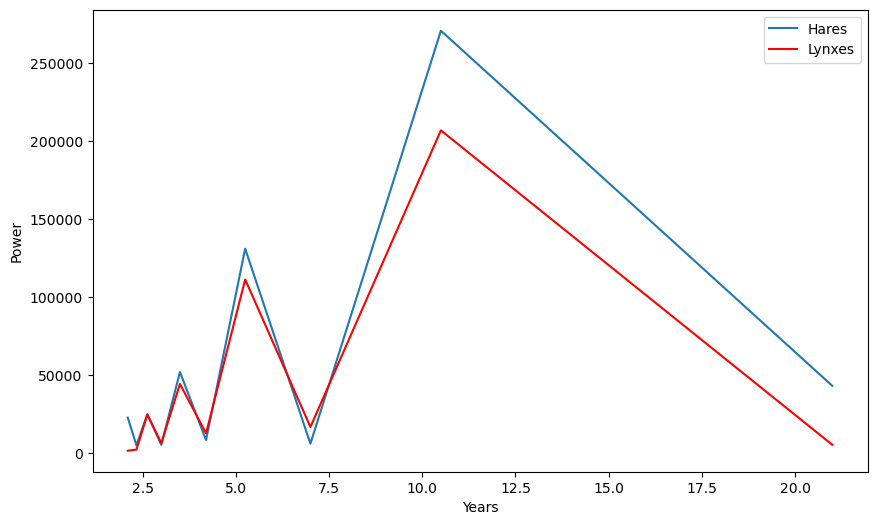

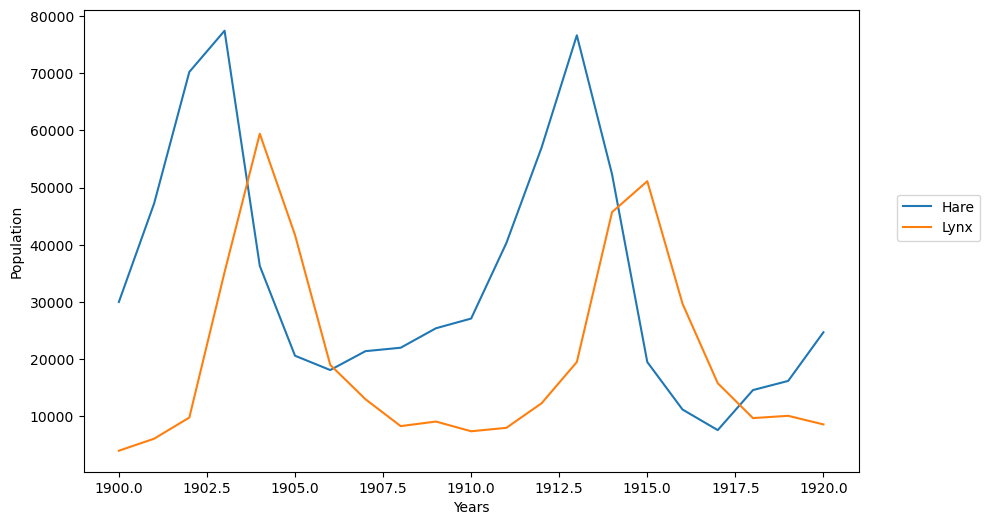

In [10]:
import csv
import pandas as pd
#!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/
#!cat data/populations.txt
filename = "data/populations.txt"

data = np.loadtxt('data/populations.txt')
years, hares, lynxes, carrots = data.T 
print("\nYear", years, "\n\nHare",hares, "\n\nLynx",lynxes , "\n\nCarrot", carrots)

#periodicity analysis: determine the period of the population of these animals -> hare, lynx, carrot
# The FFT of the samples
sig_fft_hare = fftpack.fft(hares)
print("\nFFT of hares\n", sig_fft_hare)
sig_fft_lynx = fftpack.fft(lynxes)
print("\nFFT of lynxes\n", sig_fft_lynx)

# by computing the module we get the "weights" of the Fourier components for each discrete frequency interval
power_hare = np.abs(sig_fft_hare) 
power_lynx = np.abs(sig_fft_lynx) 

# take the corresponding frequencies
sample_freq_hare = fftpack.fftfreq(len(hares), d=1)
sample_freq_lynx = fftpack.fftfreq(len(lynxes), d=1)

# Find the peak frequency: consider only the positive frequencies
pos_freq_hare = np.where(sample_freq_hare > 0)
pos_freq_lynx = np.where(sample_freq_lynx > 0)

freqs_hare = sample_freq_hare[pos_freq_hare]
freqs_lynx = sample_freq_hare[pos_freq_lynx]
powes_hare = power_hare[pos_freq_hare]
powes_lynx = power_lynx[pos_freq_lynx]

print("\npositive frequencies for hares: ",freqs_hare)
print("\npositive frequencies for lynxes: ",freqs_lynx)


# Plot the FFT power
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(1/freqs_hare, powes_hare,label="Hares")
ax.set_xlabel('Years')
ax.set_ylabel('Power')
ax.plot(1/freqs_lynx, powes_lynx, color="red", label="Lynxes")
ax.legend()


# find the max of freqs array
peak_freq_hare = freqs_hare[powes_hare.argmax()]
print("\nPeak frequency of hares:", peak_freq_hare)
peak_freq_lynx = freqs_lynx[powes_lynx.argmax()]
print("Peak frequency of lynxes:", peak_freq_lynx)
T_hare = 1 / peak_freq_hare
T_lynx = 1 / peak_freq_lynx
print("\nPeriod of population of hares:", T_hare, "years")
print("Period of population of lynxes:", T_lynx, "years")

#plot the original data to show the periodicity
fig,ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Years')
ax.set_ylabel('Population')
ax.plot(years, hares,years, lynxes) 
ax.legend(('Hare', 'Lynx'), loc=(1.05, 0.5))

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

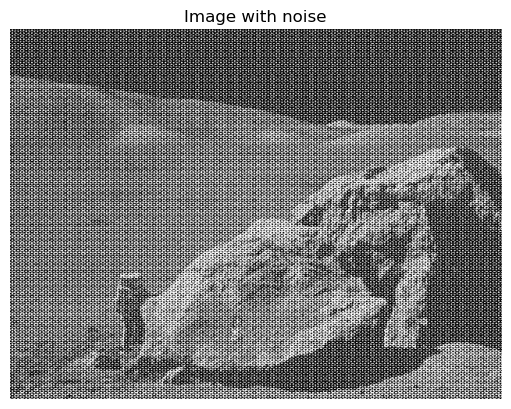

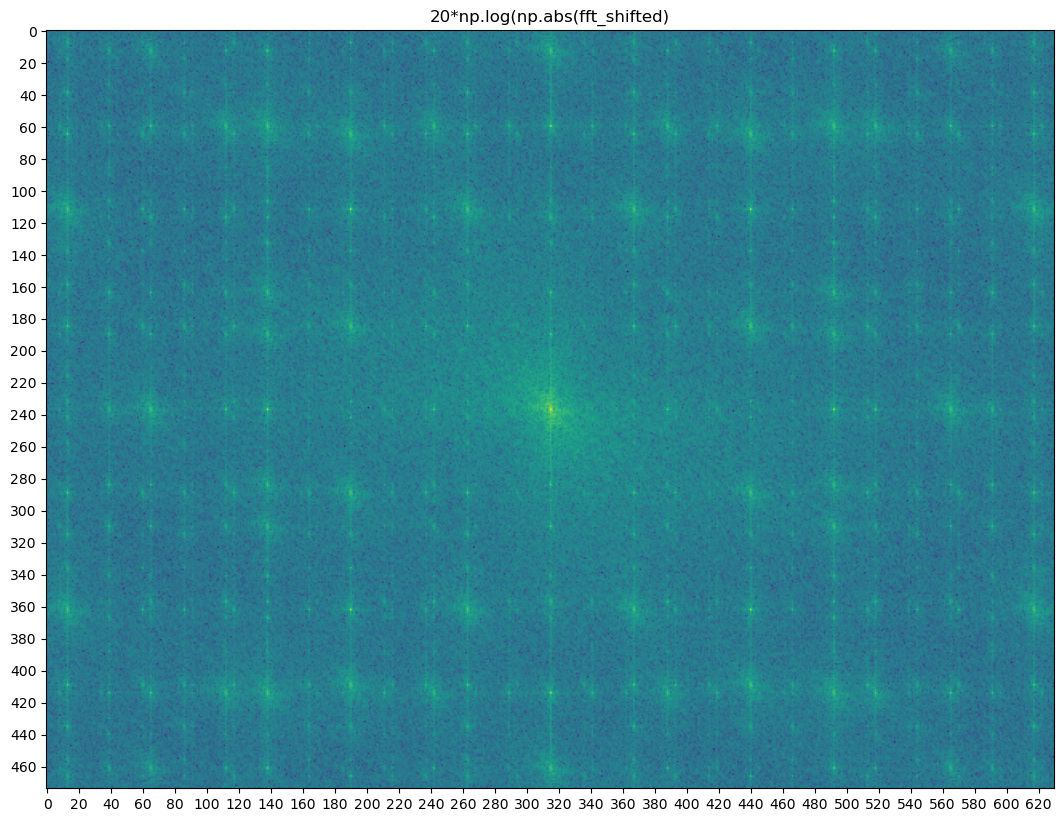

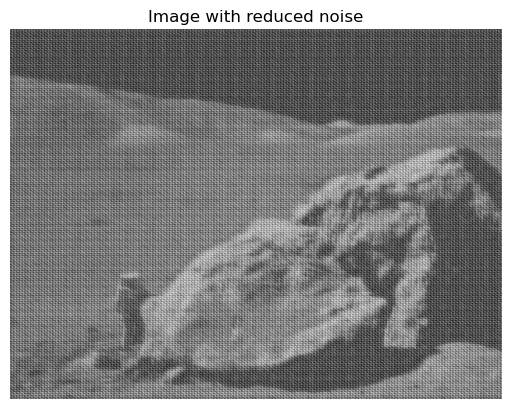

In [7]:
from matplotlib.colors import LogNorm

'''We have 2d spectrum and we have to analyze it and recognize regions with noise and regions with useful data'''
img = plt.imread("images/moonlanding.png")
fig = plt.figure()
plt.axis('off')
plt.imshow(img,cmap = "gray")
plt.title("Image with noise", )
plt.show()

# performs a 2D FFT
fft_img = fftpack.fft2(img)
#Shift the zero-frequency component to the center of the spectrum.
fshift = np.fft.fftshift(fft_img)
#power of 2D FFT of image
power = np.abs(fft_img)

#plot
figp, axp = plt.subplots(figsize = (13,20))
plt.imshow(20*np.log(np.abs(fshift))) #or I can write plt.imshow(abs(fshift), norm=LogNorm(vmin=5))
plt.title("20*np.log(np.abs(fft_shifted)")
axp.xaxis.set_major_locator(plt.MultipleLocator(20))
axp.yaxis.set_major_locator(plt.MultipleLocator(20))

#Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal
#and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
'''
OBSERVATION: I've shifted the zero-frequency component to the center of the spectrum. Then I've try to keep only
the values at the center of the power-plot and to put to zero the other values
This approach doesn't give a good result, since it produces a blurred image (important information have been lost)

'''
put_to_zero = np.ones((fft_img.shape[0], fft_img.shape[1]), dtype=bool)
(cx, cy) = (img.shape[0] // 2, img.shape[1] // 2)
d1 = 107
d2 = 107
bound_left = cx - d1
bound_right = cx + d1
bound_up = cy - d2
bound_down = cy + d2
'''
for i in range(bound_up, bound_down):
    for j in range(bound_left, bound_right):
        mask[i,j] = False'''
put_to_zero[bound_up: bound_down, bound_left: bound_right] = False
fshift[put_to_zero] = 0

'''
A second solution could be establishing a condition for values of the fft by creating a mask 
mask = power > 2000
fft_img[mask] = 0
'''


img_no_noise = fftpack.ifft2(np.fft.ifftshift(fshift))
fig2 = plt.figure()
plt.title("Image with reduced noise")
plt.axis('off')
plt.imshow(np.real(img_no_noise), cmap = "gray")
plt.show()



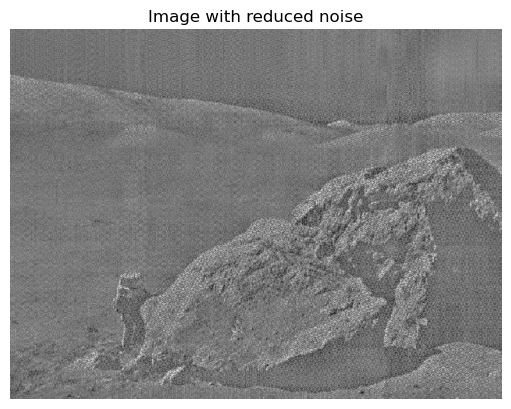

In [8]:
'''
An interesting solution is performing the fft on rows and columns instead of the fft2 on the whole image.
For each row I've perfomed the fft and I've put to zero the element in the fft-row that gave the bigger value of abs(fft)
Then I compute the ifft function and I've sobstituted  the original row in the image with the result of the inverse 
discrete Fourier Transform.
The same procedure has been applied to all columns.
The whole method can be replicated t times in the whole image and this would improve the image with noise reduction
'''

img = plt.imread("images/moonlanding.png")
to_delete = []
# performs a 2D FFT
for t in range(10):
    for j in range(img.shape[1]):
        fft = fftpack.fft(img[:,j])
        powes = np.abs(fft)
        # The return the corresponding frequencies
        sample_freq = fftpack.fftfreq(img.shape[0], d=1)

        # Find the peak frequency: focus only on only the positive frequencies
        # find the max of freqs array
        fft[powes.argmax()] = 0
        img[:,j] =np.real( fftpack.ifft(fft))
for t in range(10):
    for i in range(img.shape[0]):
        fft = fftpack.fft(img[i,:])
        powes = np.abs(fft)
        # The return the corresponding frequencies
        sample_freq = fftpack.fftfreq(img.shape[1], d=1)

        # Find the peak frequency: focus only on only the positive frequencies
        # find the max of freqs array
        fft[powes.argmax()] = 0
        img[i,:] =np.real( fftpack.ifft(fft))
    
fig2 = plt.figure()
plt.title("Image with reduced noise")
plt.axis('off')
plt.imshow(np.real(img), cmap = "gray")
plt.show()